<a href="https://colab.research.google.com/github/Xxwo2/Instacart_market_analysis/blob/main/instacart_more_reference_(more_RAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference
- light GBM benchmark 0.3692 (https://www.kaggle.com/paulantoine/light-gbm-benchmark-0-3692/code
- Vishal-Mendekar/Instacart-Market-Basket-Analysis (https://github.com/Vishal-Mendekar/Instacart-Market-Basket-Analysis)


Further work
- understand how to optimize threshold, maybe from Faron's code
- understand more on LightGBM
- need more features from KazukiOnodera(2nd place) and more
- interpret the analysis including feature importance...
- learn the workflow such as the use of utils...
- more to learn in Medium reading list & Kaggle bookmark

more to learn 
- KazukiOnodera (https://github.com/KazukiOnodera/Instacart/tree/master/py_feature)
- competition summary (https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/38130)
- metrics (https://www.zhihu.com/question/30643044)
- classification threshold (https://developers.google.com/machine-learning/crash-course/classification/thresholding?hl=zh_cn)





# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb

priors = pd.read_csv('/content/drive/MyDrive/instacart/order_products__prior.csv')
train = pd.read_csv('/content/drive/MyDrive/instacart/order_products__train.csv')
orders = pd.read_csv('/content/drive/MyDrive/instacart/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/instacart/products.csv')


print('priors {}: {}'.format(priors.shape,','.join(priors.columns)))
print('priors {}: {}'.format(orders.shape,','.join(orders.columns)))
print('priors {}: {}'.format(train.shape,','.join(train.columns)))

priors (32434489, 4): order_id,product_id,add_to_cart_order,reordered
priors (3421083, 7): order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
priors (1384617, 4): order_id,product_id,add_to_cart_order,reordered


In [5]:
#computing product f

prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders/prods.orders).astype(np.float32)
products = products.join(prods, on = 'product_id')
products.set_index('product_id',drop = False, inplace = True)



In [6]:
del prods

In [7]:
orders.set_index('order_id', inplace = True, drop = False)
priors = priors.join(orders, on = 'order_id', rsuffix='_')
priors.drop('order_id_', inplace = True, axis = 1)

In [8]:
# user feature

usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = users.all_products.map(len).astype(np.int16)

users = users.join(usr)
del usr

users['average_basket'] = (users.total_items/users.nb_orders).astype(np.float32)


In [9]:
users.head()
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
# userXproduct 

priors['user_product'] = priors.product_id+priors.user_id * 100000

In [11]:
d = dict()
for row in priors.itertuples():
  z = row.user_product
  if z not in d:
    d[z] = (1, (row.order_number, row.order_id), row.add_to_cart_order)
  else:
    d[z] = (d[z][0] + 1, max(d[z][1], (row.order_number, row.order_id)), d[z][2] + row.add_to_cart_order)



userXproduct = pd.DataFrame.from_dict(d, orient = 'index')
del d 
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x : x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)


In [12]:
del priors

In [13]:
# train / test orders 

test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id','product_id'], inplace = True, drop = False)

In [14]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2539329,2539329,1,prior,1,2,8,NaN
2398795,2398795,1,prior,2,3,7,15.0
473747,473747,1,prior,3,3,12,21.0
2254736,2254736,1,prior,4,4,7,29.0
431534,431534,1,prior,5,4,15,28.0


In [15]:
i = 0
for row in train_orders.head().itertuples():
    o_list = []
    p_list = []
    l = []
    i+=1
    if i%10000 == 0: print('order row',i)
    o_id = row.order_id
    print(o_id)
    u_id = row.user_id
    print(u_id)
    u_products = users.all_products[u_id]
    print(u_products)
    p_list += u_products
    print(p_list)
    o_list += [o_id] * len(u_products)
    print(o_list)
    l += [(o_id, product) in train.index for product in u_products]
    print(l)

1187899
1
{17122, 196, 26405, 46149, 14084, 13032, 26088, 39657, 12427, 25133, 35951, 38928, 10258, 30450, 49235, 10326, 13176, 41787}
[17122, 196, 26405, 46149, 14084, 13032, 26088, 39657, 12427, 25133, 35951, 38928, 10258, 30450, 49235, 10326, 13176, 41787]
[1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899, 1187899]
[False, True, True, True, False, True, True, True, False, True, False, True, True, False, True, False, False, False]
1492625
2
{45066, 2573, 18961, 23, 32792, 1559, 22559, 13351, 47144, 45613, 10305, 35917, 3151, 79, 48210, 46676, 27737, 18523, 5212, 20574, 7781, 8296, 47209, 19051, 22124, 19057, 20084, 49273, 40571, 16521, 47766, 21150, 33957, 47792, 30908, 24768, 5322, 28874, 16589, 21709, 27344, 19156, 14553, 12000, 21227, 5869, 28918, 38656, 40198, 37646, 44303, 5907, 24852, 27413, 30489, 7963, 8479, 46886, 19240, 22825, 49451, 22829, 20785, 32052, 41787, 27966, 1722

In [16]:
#train_orders.head().order_id

u_id
users.all_products[u_id]
o_id
o_list
u_products
p_list
l
# (o_id, product)
train.index
train

order_id  product_id  add_to_cart_order  reordered
order_id product_id                                                    
1        49302              1       49302                  1          1
         11109              1       11109                  2          1
         10246              1       10246                  3          0
         49683              1       49683                  4          0
         43633              1       43633                  5          1
...                       ...         ...                ...        ...
3421063  14233        3421063       14233                  3          1
         35548        3421063       35548                  4          1
3421070  35951        3421070       35951                  1          1
         16953        3421070       16953                  2          1
         4724         3421070        4724                  3          1

[1384617 rows x 4 columns]

In [17]:
def features(selected_orders, labels_given = False):
  order_list = []
  product_list = []
  labels = []
  i = 0
  for row in selected_orders.itertuples():
    i+=1
    if i%10000 == 0: print('order row',i)
    order_id = row.order_id
    user_id = row.user_id
    user_products = users.all_products[user_id]
    product_list += user_products
    order_list += [order_id] * len(user_products)
    if labels_given:
      labels += [(order_id, product) in train.index for product in user_products]
    
  df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
  labels = np.array(labels, dtype = np.int8)
  del order_list
  del product_list

  print('user related features')
  df['user_id'] = df.order_id.map(orders.user_id)
  df['user_total_orders'] = df.user_id.map(users.nb_orders)
  df['user_total_items'] = df.user_id.map(users.total_items)
  df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
  df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
  df['user_average_basket'] = df.user_id.map(users.average_basket)

  print('order related features')
  df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
  df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
  df['days_since_ratio'] = df.days_since_prior_order/df.user_average_days_between_orders


  print('product related feature')
  df['aisle_id'] = df.product_id.map(products.aisle_id)
  df['department_id'] = df.product_id.map(products.department_id)
  df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
  df['product_reorders'] = df.product_id.map(products.reorders)
  df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

  print('print_X_product related features')
  df['z'] = df.user_id*100000 + df.product_id
  df.drop(['user_id'], axis = 1, inplace = True)
  df['UP_orders'] = df.z.map(userXproduct.nb_orders)
  df['UP_orders_ratio'] = (df.UP_orders/df.user_total_orders).astype(np.float32)
  df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
  df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart)/df.UP_orders).astype(np.float32)
  df['UP_reorder_rate'] = (df.UP_orders/df.user_total_orders).astype(np.float32)
  df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
  df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x : min(x, 24-x)).astype(np.int8)

  df.drop(['UP_last_order_id','z'], axis = 1, inplace = True)
  print(df.dtypes)
  print(df.memory_usage())
  return (df, labels)

In [18]:
df_train, labels = features(train_orders, labels_given = True)

order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related feature
print_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                 

In [19]:
labels.sum()

828824

In [20]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
        'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order', 'aisle_id', 'department_id',

## Train test split

In [21]:
from sklearn.model_selection import train_test_split

df_train.replace([np.inf, -np.inf],np.nan, inplace = True)
df_train.fillna(df_train.mean(),inplace = True)

X = df_train
Y = labels

x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2, random_state = 14)

print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (6779728, 21) (6779728,)
test (1694933, 21) (1694933,)


## Logistic

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(x_train[f_to_use], y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
from sklearn.metrics import classification_report, f1_score
y_pred = logreg.predict(x_test[f_to_use])
y_true = y_test

print(f1_score(y_pred, y_true))
print(classification_report(y_true, y_pred))

0.06902948145885998
              precision    recall  f1-score   support

           0       0.91      1.00      0.95   1529168
           1       0.55      0.04      0.07    165765

    accuracy                           0.90   1694933
   macro avg       0.73      0.52      0.51   1694933
weighted avg       0.87      0.90      0.86   1694933



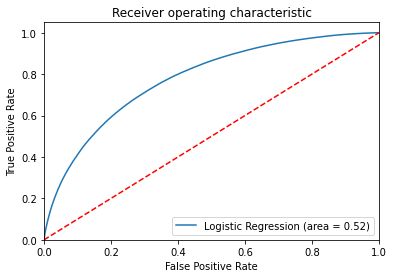

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt



logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test[f_to_use]))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test[f_to_use])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [25]:
x_test_w_pred = x_test.copy()
x_test_w_pred['prob'] = logreg.predict_proba(x_test[f_to_use])[:,1]

In [27]:
x_test_w_pred.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,prob
2544334,1771953,26369,6,102,64,11.800000,17.000000,14,5.0,0.423729,83,4,29296,18790.0,0.641384,1,0.166667,20.0,0.166667,3,4,0.151376
990662,229236,27521,5,39,29,30.000000,7.800000,9,30.0,1.000000,83,4,43067,29936.0,0.695103,1,0.200000,4.0,0.200000,4,5,0.156006
4482875,17637,39024,4,43,37,21.333334,10.750000,16,14.0,0.656250,116,1,4127,1650.0,0.399806,1,0.250000,10.0,0.250000,2,3,0.147933
4264697,512561,19180,75,871,242,3.797297,11.613334,8,3.0,0.790036,107,19,2197,1525.0,0.694128,1,0.013333,16.0,0.013333,8,0,0.015918
1025019,1097090,6689,14,281,149,20.769230,20.071428,9,24.0,1.155556,114,17,724,189.0,0.261050,1,0.071429,16.0,0.071429,8,4,0.067060


## LightGBM

In [110]:
lgb_model = lgb.LGBMClassifier(boosting_type = 'gbdt', n_estimators=100, max_depth = 3)
lgb_model.fit(x_train[f_to_use], y_train)

formating for lgb


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [111]:
y_pred_l = lgb_model.predict_proba(x_test[f_to_use])[:,1] >= 0.21
y_true_l = y_test

print(f1_score(y_pred_l, y_true_l))
print(classification_report(y_true_l, y_pred_l))

0.43480666443961913
              precision    recall  f1-score   support

           0       0.94      0.91      0.93   1529168
           1       0.38      0.50      0.43    165765

    accuracy                           0.87   1694933
   macro avg       0.66      0.71      0.68   1694933
weighted avg       0.89      0.87      0.88   1694933



In [28]:
d_train = lgb.Dataset(x_train[f_to_use],
                      label=y_train
                      # categorical_feature=['aisle_id', 'department_id']
                      )  # , 'order_hour_of_day', 'dow'

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train :-)')
bst = lgb.train(params, d_train, ROUNDS)
# lgb.plot_importance(bst, figsize=(9,20))

light GBM train :-)


In [29]:
y_pred_lm = bst.predict(x_test[f_to_use]) >= 0.21
y_true_lm = y_test

print(f1_score(y_pred_lm, y_true_lm))
print(classification_report(y_true_lm, y_pred_lm))

0.4429019441703306
              precision    recall  f1-score   support

           0       0.95      0.91      0.93   1529168
           1       0.39      0.52      0.44    165765

    accuracy                           0.87   1694933
   macro avg       0.67      0.71      0.69   1694933
weighted avg       0.89      0.87      0.88   1694933



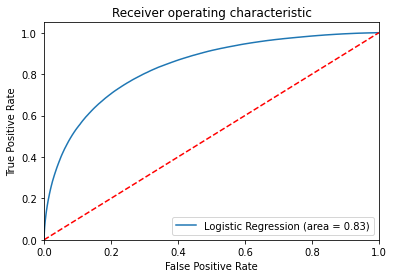

In [30]:
logit_roc_auc = roc_auc_score(y_true_lm, bst.predict(x_test[f_to_use]))
fpr, tpr, thresholds = roc_curve(y_true_lm, bst.predict(x_test[f_to_use]))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [31]:
y_p_value = bst.predict(x_test[f_to_use])

,index,threshold
94282,94282,0.209988
94283,94283,0.209987
94284,94284,0.209985
94285,94285,0.209984
94286,94286,0.209982
...,...,...
108076,108076,0.180009
108077,108077,0.180008
108078,108078,0.180008
108079,108079,0.180003


In [32]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
  y_p = np.where(bst.predict(x_test[f_to_use])>thres,1,0)
  accuracy_ls.append(accuracy_score(y_test, y_p, normalize = True))

accuracy_df = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)], axis = 1)
accuracy_df.columns = ['threshold', 'accuracy']
accuracy_df.sort_value('accuracy', ascending = False, inplace = True)

KeyboardInterrupt: ignored

In [ ]:
accuracy_df

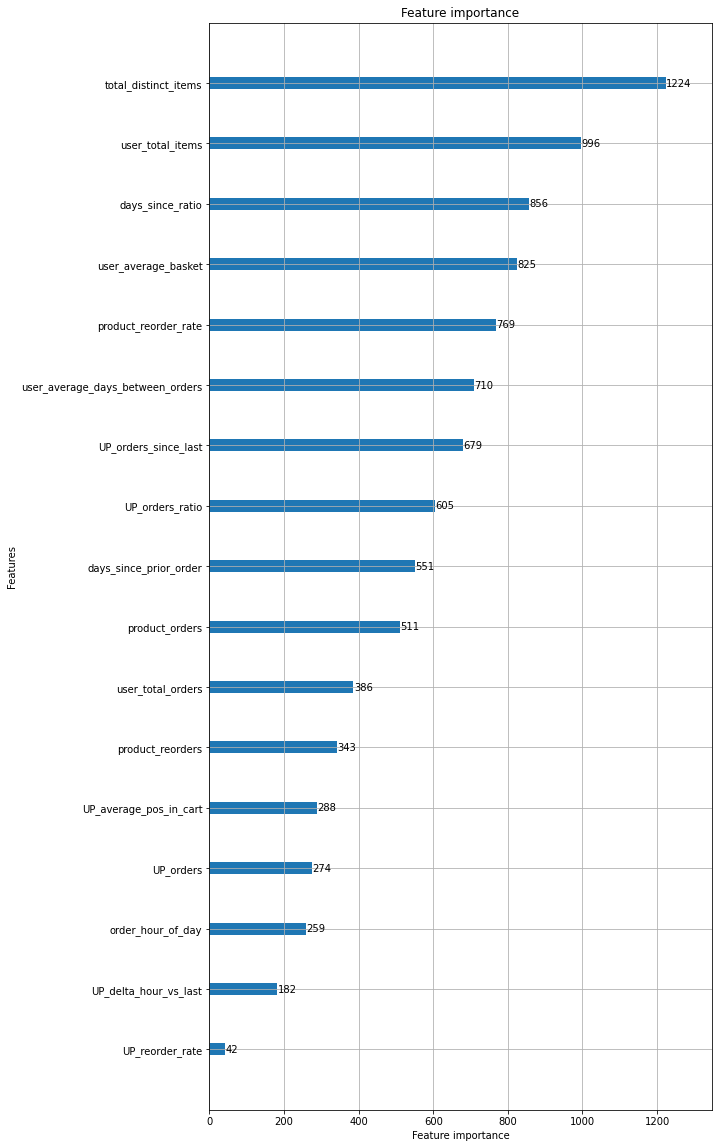

In [124]:
lgb.plot_importance(bst, figsize=(9,20))